## Useful Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Load Dataset file

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
imdb_dataset = pd.read_csv('/content/drive/MyDrive/data/IMDB Dataset.csv')

## Explore Data

In [5]:
imdb_dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
imdb_dataset.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [7]:
imdb_dataset.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [8]:
imdb_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


### Visualize the distribution of sentiment labels (Positive and Negative)

<Axes: title={'center': 'Distribution of Sentiment Labels'}, xlabel='sentiment', ylabel='count'>

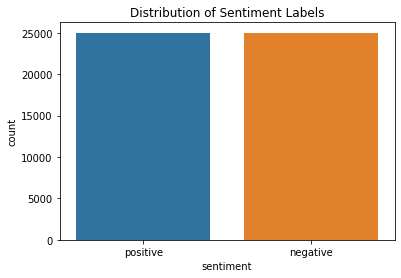

In [9]:
plt.title('Distribution of Sentiment Labels')
sns.countplot(data=imdb_dataset, x='sentiment')

We see that the number of instances in the the two sentiment labels (Positive and Negative) are roughly the same, so this means that it is a balanced dataset and there is no class imbalance problem here, and we can use **Accuracy** as the performance metric

In [10]:
X = imdb_dataset.drop(columns=['sentiment'])
y = imdb_dataset[['sentiment']]

## Cleaning and Encoding the IMDB Reviews

We will clean now the IMDB Reviews by performing the following cleaning steps:
1. Remove HTML tags and special characters
2. Remove punctuation and lowercase text
3. Remove stop words
4. Lemmatization

We will encode the sentiment labels and convert them to **one hot encoding**

In [11]:
def clean_imdb(text):
    """
    Cleans a string of text by performing the following steps:
    1. Removes HTML tags from the text using BeautifulSoup.
    2. Removes non-alphanumeric characters (including punctuation) from the text using regular expressions and
    converts the text to lowercase.
    3. Tokenizes the text into a list of words using the `nltk.word_tokenize()` function.
    4. Removes stop words from the list of words using the `nltk.corpus.stopwords()` module.
    5. Lemmatizes the list of words using the `nltk.stem.WordNetLemmatizer()` class.
    6. Joins the lemmatized list of words back into a single string.

    Args:
        text (str): A string of text to be cleaned.

    Returns:
        str: A cleaned version of the input text.
    """
    # Remove HTML tags and special characters
    text = BeautifulSoup(text, "html.parser").get_text()  # remove HTML tags
    text = text.lower() # convert to lowercase
    text = re.sub(r"[^a-zA-Z0-9 ]", "", text)  # remove non-alphanumeric characters

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Initialize the Porter Stemmer
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Join the tokens back into a single string
    cleaned_text = " ".join(tokens)

    return cleaned_text

In [12]:
# clean the imdb reviews data
X_cleaned = X['review'].apply(clean_imdb)
X_cleaned = pd.DataFrame(X_cleaned,columns=['review'])
# encode the sentiment labels
y_encoded = pd.get_dummies(y, columns=['sentiment'])

<ipython-input-11-4e7c8a230782>:19: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()  # remove HTML tags


## Divide the data into Train and Test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_encoded, test_size=0.1, random_state=42)
print('The shape of X_train is', X_train.shape, 'and the shape of y_train is', y_train.shape)
print('The shape of X_test is', X_test.shape, 'and the shape of y_test is', y_test.shape)

The shape of X_train is (45000, 1) and the shape of y_train is (45000, 2)
The shape of X_test is (5000, 1) and the shape of y_test is (5000, 2)


## Tokenization and Vectorization of IMDB Reviews

We will Split the text into individual words or tokens.and then Convert the text data into numerical vectors that can be fed into a deep learning model

In [22]:
MAX_LEN = 250 # max length of padded sequences
VOCAB_SIZE = 50000

In [23]:
vectorizer_layer = TextVectorization(
        max_tokens= VOCAB_SIZE,
        output_sequence_length= MAX_LEN,
    )
vectorizer_layer.adapt(X_train['review'])

## Deep Learnig  Model Architecture

In [34]:
# hyperparameters
LOSS = 'binary_crossentropy'
OPTIMIZER = 'adam'
METRICS = ['accuracy']
ACTIVATION_OUTPUT = 'softmax'
ACTIVATION_LAYER = 'relu'
LSTM_UNITS = 128
OUTPUT_DIM = 32
BATCH_SIZE = 128
EPOCHS = 8

In [38]:
def imdb_model(input_dim, output_dim, lstm_units, activation_layer, activation_output, max_len, loss, optimizer, metrics):
    model = Sequential([
        tf.keras.Input(shape=(1,), dtype=tf.string),
        vectorizer_layer,
        Embedding(input_dim= input_dim, output_dim= output_dim, input_length= max_len),
        Bidirectional(LSTM(units= lstm_units)),
        Dropout(rate=0.4),
        Dense(units=32, activation = activation_layer),
        Dense(units=2, activation= activation_output)
    ])
    
    model.compile(loss= loss, optimizer= optimizer, metrics= metrics)
    return model

In [39]:
model = imdb_model(VOCAB_SIZE, OUTPUT_DIM, LSTM_UNITS, ACTIVATION_LAYER, ACTIVATION_OUTPUT, 
                   MAX_LEN, LOSS, OPTIMIZER, METRICS)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 250)              0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 250, 32)           1600000   
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              164864    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 32)                8224      
                                                                 
 dense_11 (Dense)            (None, 2)                

## Model Training

In [40]:
history = model.fit(X_train, y_train, batch_size= BATCH_SIZE, epochs= EPOCHS, validation_split= 0.1)

Epoch 1/8
317/317 [==============================] - 45s 129ms/step - loss: 0.4294 - accuracy: 0.7890 - val_loss: 0.2832 - val_accuracy: 0.8891
Epoch 2/8
317/317 [==============================] - 30s 95ms/step - loss: 0.2062 - accuracy: 0.9249 - val_loss: 0.3134 - val_accuracy: 0.8873
Epoch 3/8
317/317 [==============================] - 25s 78ms/step - loss: 0.1394 - accuracy: 0.9517 - val_loss: 0.3513 - val_accuracy: 0.8787
Epoch 4/8
317/317 [==============================] - 19s 59ms/step - loss: 0.0946 - accuracy: 0.9687 - val_loss: 0.3738 - val_accuracy: 0.8749
Epoch 5/8
317/317 [==============================] - 17s 53ms/step - loss: 0.0830 - accuracy: 0.9727 - val_loss: 0.4272 - val_accuracy: 0.8782
Epoch 6/8
317/317 [==============================] - 17s 53ms/step - loss: 0.0605 - accuracy: 0.9807 - val_loss: 0.4464 - val_accuracy: 0.8796
Epoch 7/8
317/317 [==============================] - 16s 51ms/step - loss: 0.0379 - accuracy: 0.9891 - val_loss: 0.5176 - val_accuracy: 0.876

In [41]:
def plot_curves(history):
    """
    Plots the loss and accuracy curves for a model.

    Parameters:
    - history: A history object returned by a model during training.

    Returns:
    - None. The function displays the plot using Matplotlib.
    """
    title_loss = 'Model loss per epoch '
    title_accuracy = 'Model accuracy per epoch '
    fig , axis = plt.subplots(nrows=1, ncols=2)
    # dimensions of figure
    fig.set_figheight(6)
    fig.set_figwidth(14)
    # loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    # accuracy
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epoch = np.arange(150)
    # loss curve
    axis[0].plot(loss,label='Train')
    axis[0].plot(val_loss,label='Validation')
    axis[0].set_xlabel('epoch')
    axis[0].set_ylabel('loss')
    axis[0].set_title(title_loss)
    axis[0].legend()
    # accuracy curve
    axis[1].plot(accuracy, label='Train')
    axis[1].plot(val_accuracy, label='Validation')
    axis[1].set_xlabel('epoch')
    axis[1].set_ylabel('accuracy')
    axis[1].set_title(title_accuracy)
    axis[1].legend()

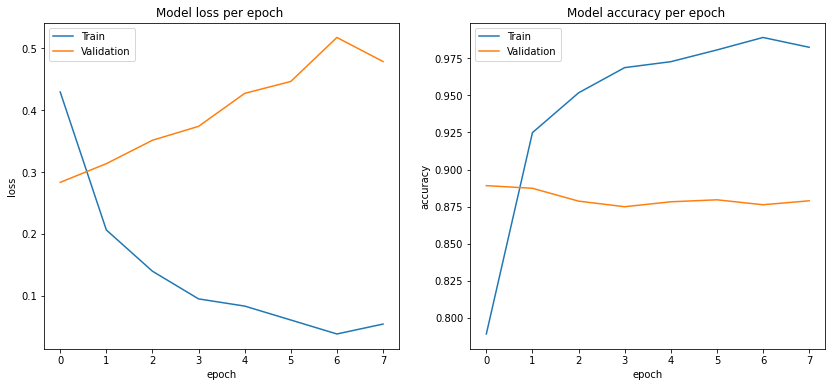

In [42]:
plot_curves(history)

In [43]:
loss, accuracy = model.evaluate(X_test,y_test)
print('The loss of the model on Test Data is:', loss)
print('The accuracy of the model on Test Data is:', accuracy)

157/157 [==============================] - 2s 12ms/step - loss: 0.4898 - accuracy: 0.8736
The loss of the model on Test Data is: 0.48977532982826233
The accuracy of the model on Test Data is: 0.8736000061035156


In [47]:
# save the model
saved_model_name = 'drive/MyDrive/data/imdb_sentiment_analysis'
model.save(saved_model_name,save_format='tf')